In [11]:
import torch
import torch.nn as nn
from torchvision.models import resnet50,resnet34
from torchvision.datasets import CIFAR10
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.nn import functional as F
from google.colab import drive 
#from pl_bolts.models.self_supervised.evaluator import Flatten

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
class SimclrDataset(Dataset):
    def __init__(self,train=True):
        self.ds = CIFAR10(".",download=True,train=train)
        self.Tens = transforms.ToTensor()
        
        
        def get_color_distortion(s=0.5):  # 0.5 for CIFAR10 by default
          # s is the strength of color distortion
          color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
          rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
          rnd_gray = transforms.RandomGrayscale(p=0.2)
          color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
          return color_distort

        data_transforms = [
            transforms.RandomResizedCrop(32),
            transforms.RandomHorizontalFlip(p=0.5),
            get_color_distortion(s=0.5),
            transforms.ToTensor()
        ]
        self.train_transform = transforms.Compose(data_transforms)

    def __len__(self):
        return(len(self.ds))
    def __getitem__(self,idx):

        sample = self.ds[idx][0]

        xi = self.train_transform(sample)
        xj = self.train_transform(sample)
        
        
        return (xi,xj)

In [5]:
train_set=SimclrDataset()
train_loader = DataLoader(train_set,batch_size=64,shuffle=True)
val_set = SimclrDataset(train=False)
val_loader = DataLoader(val_set,batch_size=64,shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


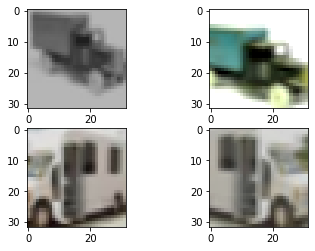

In [6]:
#print(dataiter.next()[0][0].shape)
#print(dataiter.next()[0][0][0].shape)
x =iter(train_loader).next()
plt.subplot(2, 2, 1)
plt.imshow(x[0][0].permute(1, 2, 0))
plt.subplot(2, 2, 2)
plt.imshow(x[1][0].permute(1, 2, 0))
plt.subplot(2, 2, 3)
plt.imshow(x[0][1].permute(1, 2, 0))
plt.subplot(2, 2, 4)
plt.imshow(x[1][1].permute(1, 2, 0))
plt.show()

In [7]:
def nt_xent_loss(out_1, out_2, temperature):
    out = torch.cat([out_1, out_2], dim=0)
    n_samples = len(out)

    # Full similarity matrix
    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)

    mask = ~torch.eye(n_samples, device=sim.device).bool()
    neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)

    # Positive similarity
    pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)

    loss = -torch.log(pos / neg).mean()
    return loss

In [8]:
class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        self.enc = base_encoder(pretrained=False)  
        self.feature_dim = self.enc.fc.in_features

        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3 and remove first max pooling.
        # Section B.9 of SimCLR paper.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity() 

        # MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))

    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        projection = F.normalize(projection)
        return feature, projection


In [14]:
model = SimCLR(resnet50)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)
epochs = 5

In [15]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    model_save_name = filename
    path = F"/content/drive/MyDrive/{model_save_name}" 
    print("=> Saving checkpoint")
    torch.save(state, path)


def load_checkpoint(checkpoint,model,optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    iter_train_loss = checkpoint["iter_train_loss"]
    iter_val_loss = checkpoint["iter_val_loss"]

In [16]:
load_model = True
if load_model :
  model_save_name ="my_checkpoint.pth.tar"
  path = F"/content/drive/MyDrive/{model_save_name}" 
  load_checkpoint(torch.load(path),model,optimizer)

=> Loading checkpoint


In [17]:
train_loss = []
val_loss = []
for epoch in range(epochs):
  model.train()
  if epoch % 5 == 0:
    checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : optimizer.state_dict(),
                  'iter_train_loss' : iter_train_loss ,'iter_val_loss' : iter_val_loss 
                  }
    save_checkpoint(checkpoint, filename="my_checkpoint.pth.tar")

  iter_train_loss = 0
  iter_val_loss=0

  for img_1,img_2 in train_loader:

    optimizer.zero_grad()
    img_1 = img_1.to(device)
    img_2 = img_2.to(device)
    feature_1, projection_1 = model(img_1)
    feature_2, projection_2 = model(img_2) 
    loss = nt_xent_loss(projection_1,projection_2,0.5)
    loss.backward()
    optimizer.step()
    loss = loss.item()
    iter_train_loss += loss

  train_loss.append(iter_train_loss/len(train_set))
  print("Epoch: {0} \t Loss: {1:.4f} ".format(epoch, train_loss[-1]))


  with torch.no_grad():
    model.eval()
  
    for img_1,img_2 in val_loader:
      img_1 = img_1.to(device)
      img_2 = img_2.to(device)
      feature_1, projection_1 = model(img_1)
      feature_2, projection_2 = model(img_2) 
      loss = nt_xent_loss(projection_1,projection_2,0.5)
      loss = loss.item()
      iter_val_loss +=loss
    val_loss.append(iter_val_loss/len(val_set))
  

=> Saving checkpoint
Epoch: 0 	 Loss: 0.0663 
Epoch: 1 	 Loss: 0.0662 
Epoch: 2 	 Loss: 0.0661 
Epoch: 3 	 Loss: 0.0660 
Epoch: 4 	 Loss: 0.0660 


In [ ]:
train_loss = []
val_loss = []
for epoch in range(epochs):
  model.train()
  if epoch % 5 == 1:
    checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : optimizer.state_dict(),
                  'iter_train_loss' : iter_train_loss ,'iter_val_loss' : iter_val_loss 
                  }
    save_checkpoint(checkpoint, filename="my_checkpoint.pth.tar")

  iter_train_loss = 0
  iter_val_loss=0

  for img_1,img_2 in train_loader:

    optimizer.zero_grad()
    img_1 = img_1.to(device)
    img_2 = img_2.to(device)
    feature_1, projection_1 = model(img_1)
    feature_2, projection_2 = model(img_2) 
    loss = nt_xent_loss(projection_1,projection_2,0.5)
    loss.backward()
    optimizer.step()
    loss = loss.item()
    iter_train_loss += loss

  train_loss.append(iter_train_loss/len(train_set))
  print("Epoch: {0} \t Loss: {1:.4f} ".format(epoch, train_loss[-1]))


  with torch.no_grad():
    model.eval()
  
    for img_1,img_2 in val_loader:
      img_1 = img_1.to(device)
      img_2 = img_2.to(device)
      feature_1, projection_1 = model(img_1)
      feature_2, projection_2 = model(img_2) 
      loss = nt_xent_loss(projection_1,projection_2,0.5)
      loss = loss.item()
      iter_val_loss +=loss
    val_loss.append(iter_val_loss/len(val_set))
  

Epoch: 0 	 Loss: 0.0664 
=> Saving checkpoint
Epoch: 1 	 Loss: 0.0662 
Epoch: 2 	 Loss: 0.0662 
Epoch: 3 	 Loss: 0.0661 
Epoch: 4 	 Loss: 0.0661 


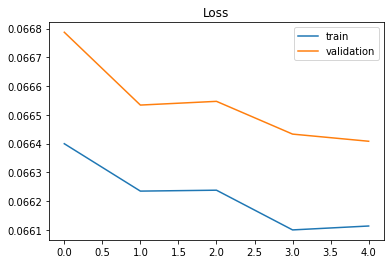

In [ ]:
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='validation')
plt.legend()
plt.title("Loss")
plt.show()

In [ ]:

print("feature_1 :",feature_1.shape)
print("projection_1 ;",projection_1.shape)

feature_1 : torch.Size([16, 2048])
projection_1 ; torch.Size([16, 128])


In [25]:
class SimCLR_classi(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.freeze = model.enc # load model from torchvision.models without pretrained weights.
        self.dt = nn.Sequential(nn.Linear(2048,10))

    def forward(self, x):
        rep = self.freeze(x)
        outt = self.dt(rep)
        return outt


In [26]:
model_class = SimCLR_classi(model)
model_class.to(device)

SimCLR_classi(
  (freeze): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bia

In [27]:
def save_checkpoint(state, filename="my_checkpoint_class.pth.tar"):
    model_save_name = filename
    path = F"/content/drive/MyDrive/{model_save_name}" 
    print("=> Saving checkpoint")
    torch.save(state, path)


def load_checkpoint(checkpoint,model,optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    iter_train_loss = checkpoint["iter_train_loss"]
    iter_val_loss = checkpoint["iter_val_loss"]
    count_corr_train = checkpoint["count_corr_train"]
    count_corr_val = checkpoint["count_corr_val"]
    train_acc = checkpoint["train_acc"]
    val_acc = checkpoint["val_acc"]
    val_loss = checkpoint["val_loss"]
    train_loss = checkpoint["train_loss"]

In [28]:
clf_train_set=CIFAR10(".",transform=transforms.ToTensor())
clf_val_set=CIFAR10(".",train=False,transform=transforms.ToTensor())
clf_train_loader = DataLoader(clf_train_set,batch_size=64,shuffle=True)
clf_val_loader = DataLoader(clf_val_set,batch_size=64,shuffle=True)

In [29]:
optimizer = torch.optim.SGD(model_class.parameters(),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

In [30]:
load_model = False
if load_model :
  model_save_name ="my_checkpoint_class.pth.tar"
  path = F"/content/drive/MyDrive/{model_save_name}" 
  load_checkpoint(torch.load(path),model_class,optimizer)

In [31]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for epoch in range(epochs):

  model.train()


  iter_val_loss = 0
  iter_acc = 0
  count_corr_train = 0
  iter_train_loss = 0
  count_corr_train =0
  count_corr_val = 0

  for X,y in clf_train_loader:

    optimizer.zero_grad()        
    X = X.to(device)
    y = y.to(device)
    out = model_class(X)
    loss = loss_fn(out,y)
    loss.backward()
    optimizer.step()
    loss = loss.item()
    iter_train_loss += loss
    pre = torch.argmax(out,dim=1)
    count_corr_train += (pre == y).sum().item()
    
    #iter_acc = accuracy_score(pre.cpu(),y.cpu())
    
  train_acc.append(count_corr_train*100/len(clf_train_set))
  train_loss.append(iter_train_loss/len(clf_train_set))
  print("Epoch: {0} \t Loss: {1:.4f} \t Accuracy: {2:.2f} ".format(epoch, train_loss[-1],train_acc[-1]))


  with torch.no_grad():
    model.eval()
    
    for X,y in clf_val_loader:
      X = X.to(device)
      y = y.to(device)
      out = model_class(X)
      loss = loss_fn(out,y)
      loss = loss.item()
      iter_val_loss +=loss
      pre = torch.argmax(out,dim=1)
      count_corr_val += (pre == y).sum().item()

      
    val_loss.append(iter_val_loss/len(clf_val_set))
    val_acc.append(count_corr_val*100/len(clf_val_set))
    


Epoch: 0 	 Loss: 0.0345 	 Accuracy: 17.72 
Epoch: 1 	 Loss: 0.0328 	 Accuracy: 21.88 
Epoch: 2 	 Loss: 0.0320 	 Accuracy: 24.08 
Epoch: 3 	 Loss: 0.0315 	 Accuracy: 25.21 
Epoch: 4 	 Loss: 0.0311 	 Accuracy: 26.82 
Epoch: 5 	 Loss: 0.0307 	 Accuracy: 27.69 
Epoch: 6 	 Loss: 0.0304 	 Accuracy: 28.51 
Epoch: 7 	 Loss: 0.0302 	 Accuracy: 29.24 
Epoch: 8 	 Loss: 0.0299 	 Accuracy: 29.86 
Epoch: 9 	 Loss: 0.0297 	 Accuracy: 30.24 
Epoch: 10 	 Loss: 0.0294 	 Accuracy: 30.86 
Epoch: 11 	 Loss: 0.0292 	 Accuracy: 31.47 
Epoch: 12 	 Loss: 0.0290 	 Accuracy: 32.09 
Epoch: 13 	 Loss: 0.0288 	 Accuracy: 32.34 
Epoch: 14 	 Loss: 0.0286 	 Accuracy: 32.60 
Epoch: 15 	 Loss: 0.0285 	 Accuracy: 33.21 
Epoch: 16 	 Loss: 0.0283 	 Accuracy: 33.36 
Epoch: 17 	 Loss: 0.0281 	 Accuracy: 33.57 
Epoch: 18 	 Loss: 0.0280 	 Accuracy: 34.15 
Epoch: 19 	 Loss: 0.0279 	 Accuracy: 34.53 
Epoch: 20 	 Loss: 0.0277 	 Accuracy: 34.67 
Epoch: 21 	 Loss: 0.0275 	 Accuracy: 35.05 
Epoch: 22 	 Loss: 0.0275 	 Accuracy: 35.28

In [ ]:
  if epoch % 10 == 1:
    checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : optimizer.state_dict(),
                  'iter_train_loss' : iter_train_loss ,'iter_val_loss' : iter_val_loss ,
                  'count_corr_train' : count_corr_train,'count_corr_val': count_corr_val,
                  'train_acc':train_acc,'train_loss' : train_loss,'val_loss': val_loss,
                  'val_acc': val_acc
                  }
    save_checkpoint(checkpoint, filename="my_checkpoint_class.pth.tar")

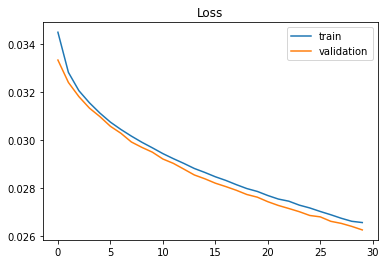

In [32]:
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='validation')
plt.legend()
plt.title("Loss")
plt.show()

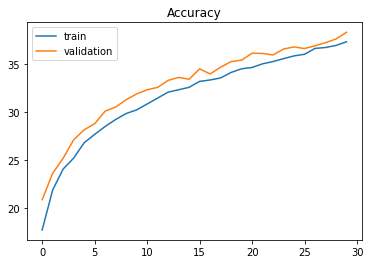

In [33]:
plt.plot(train_acc,label='train')
plt.plot(val_acc,label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()